In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from graph_tool import *
from graph_tool import topology
from graph_tool import draw
from graph_tool import inference
from graph_tool import clustering

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from copy import copy

In [5]:
from collections import Counter

In [6]:
import matplotlib

# 1 Structural Roles: Rolx and ReFex

**1.1 Basic feauteres**  

Load the graph provided in the bundle, and compute three basic features for the nodes. For each node v, we choose 3 basic local features (in this order): 
1. the degree of v, i.e., deg(v);
2. the number of edges in the egonet of v, where egonet of v is defined as a subgraph whose nodes are v, and its neighbors and edges are induced from the whole graph;
3. the number of edges that connects the egonet of v and the rest of the graph, i.e., the number of edges that enters or leaves the egonet of v.


We use $\tilde{V_u}$ to represent the vector of the basic features of node u. For any pair of nodes u and v, we can use cosine similarity to measure how similar two nodes are according to their feature vectors x and y:


$$Sim(x, y) = \frac{xy}{||x||^2||y||^2}=\frac{\sum_i{x_i*y_i}}{\sqrt{\sum_i{y_i^2}}*\sqrt{\sum_i{x_i^2}}}$$  Also, when $||x||^2 = 0$ or $||y||^2 = 0$, $Sim(x, y) = 0$.  
For node with ID 9, what is the basic feature vector for it? Report the top 5 nodes that are most similar to node 9

For sanity check, no element in $\tilde{V_9}$ is larger than 10

In [7]:
netScience = load_graph("data/netscience.gml")

In [8]:
print("Graph Science Network\n%d vertices\n%d edges" % (netScience.num_vertices(), netScience.num_edges()))

Graph Science Network
1589 vertices
2742 edges


In [9]:
pos = draw.sfdp_layout(netScience)

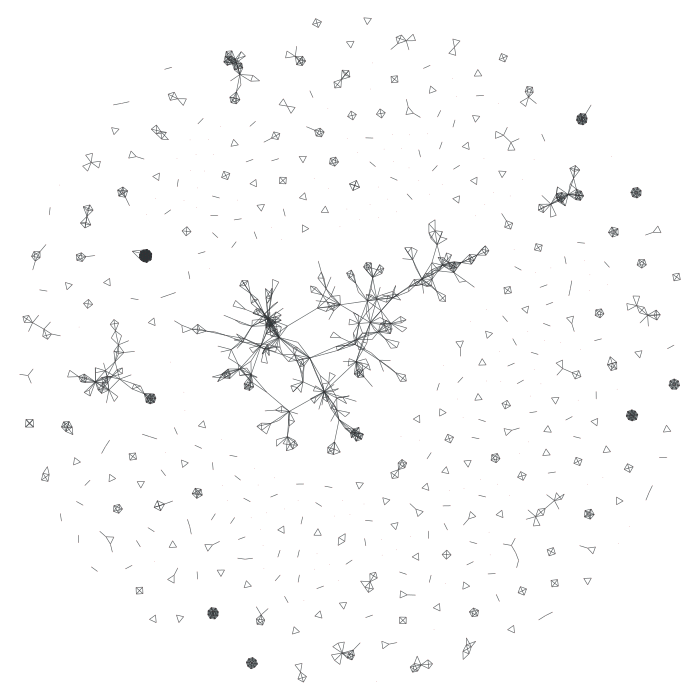

In [10]:
draw.graph_draw(netScience, pos, output_size=(700, 700),
                vertex_size=0.5, edge_pen_width=0.6, output="plots/netScience.png")
plt.show()

In [11]:
def getProperties(v):
    degree = v.in_degree() + v.out_degree()
    innerEdgesOfEgoNet = 0
    outerEdgesOfEgoNet = 0
    
    egoNet = list(v.all_neighbors())
    egoNet.append(v)
    
    for neighbor in egoNet:
        for eIn in neighbor.in_edges():
            if eIn.source() in egoNet:
                innerEdgesOfEgoNet += 1
            else:
                outerEdgesOfEgoNet += 1
        
        for eOut in neighbor.out_edges():
            if eOut.target() in egoNet:
                innerEdgesOfEgoNet += 1
            else:
                outerEdgesOfEgoNet += 1
    
    return [degree, innerEdgesOfEgoNet // 2, outerEdgesOfEgoNet]

In [12]:
features = []

In [13]:
for v in netScience.vertices():
    features.append(getProperties(v))

In [14]:
features = np.array(features)

In [15]:
def getNodeSimilarity(f1, f2):
    sim = np.sum(f1*f2) / (np.linalg.norm(f1)*np.linalg.norm(f2))
    if np.isnan(sim):
        sim = 0.0
    return sim

In [16]:
node9similarity = {}

In [17]:
for i in range(features.shape[0]):
    node9similarity[i] = getNodeSimilarity(features[i, :], features[9, :])

In [18]:
sorted(node9similarity.items(), key=lambda kv: kv[1], reverse=True)[:6]

[(9, 1.0),
 (415, 0.9996157540684272),
 (286, 0.996343680627828),
 (288, 0.996343680627828),
 (1054, 0.9961182380000687),
 (1336, 0.9961182380000687)]

**1.2 Recoursive features**  
In this next step, we recursively generate some more features. We use mean and sum as aggregation functions.
Initially, we have a feature vector $\tilde{V_u} \in R^3$ for every node u. In the first iteration, we concatenate the mean of all u’s neighbors’ feature vectors to $\tilde{V_u}$, and do the same for sum, i.e.,
$$\tilde{V}_{u}^{(1)} = [\tilde{V_u}; \frac{1}{|N(u)|}\sum_{v \in N(u)}{\tilde{V_u}};\sum_{v \in N(u)}{\tilde{V_u}}] \in R^9$$
where $N(u)$ is the set of u’s neighbors in the graph. If $N(u) = \oslash$, set the mean and sum to 0.  After K iterations, we obtain the overall feature matrix $V = \tilde{V}(K) \in R^{3K + 1}$.  
For this exercise, run K = 2 iterations, and report the top 5 nodes that are most similar to node 9. If there are ties, e.g. 4th, 5th, and 6th have the same similarity, report any of them to fill up the top-5 ranking. (For sanity check, the similarity between the reported nodes and node 9 are greater than 0.9)

In [19]:
def oneIteration(v, currentFeatures):
    newFeatureVector = []
    newFeatureVector.append(currentFeatures[int(v), :])
    
    sumFeatures = np.zeros(currentFeatures[int(v), :].shape)
    nNeighbors = 0
    
    for neighbor in v.all_neighbors():
        sumFeatures += currentFeatures[int(neighbor), :]
        nNeighbors += 1
    
    if (nNeighbors != 0):
        meanFeatures = sumFeatures / nNeighbors
    else:
        meanFeatures = np.zeros(currentFeatures[int(v), :].shape)
    
    newFeatureVector.append(meanFeatures)
    newFeatureVector.append(sumFeatures)
    
    return newFeatureVector   

In [20]:
def updateFeatures(currentFeatures):
    newFeatures = []
    for v in netScience.vertices():
        newFeatures.append(oneIteration(v, currentFeatures))
        
    return np.array(newFeatures)

In [21]:
featuresK1 = updateFeatures(features)
featuresK2 = updateFeatures(featuresK1)

In [22]:
featuresK2.shape

(1589, 3, 3, 3)

In [23]:
node9similarityK2 = {}

In [24]:
for i in range(featuresK2.shape[0]):
    node9similarityK2[i] = getNodeSimilarity(featuresK2[i, :], featuresK2[9, :])

In [25]:
sorted(node9similarityK2.items(), key=lambda kv: kv[1], reverse=True)[:6]

[(9, 1.0),
 (973, 0.9959848829010804),
 (537, 0.9946130044020558),
 (415, 0.9937284425239261),
 (496, 0.9922839741918226),
 (24, 0.9922413199302672)]

**1.3 Role Discovery**  
In this part, we explore more about the graph according to the feature vector and node similarity.  
* (a) Produce a 20-bin histogram to show the distribution of cosine similarity between node 9 and any other node in the graph. (where the X-axis is cosine similarity with node 9, and the Y-axis is the number of nodes) According to the histogram, can you spot some groups / roles? How many can you spot? (Clue: look for the spikes!)  
* (b) For these groups / roles in the cosine similarity histogram, take one node u from each group to examine the feature vector, and draw the subgraph of the node based on its feature vector. (You can draw it by hand, or use libraries like networkx or graphviz.)


You should use the local features for u, and pay attention to the features aggregated from its 1-hop neighbors, but feel free to ignore further features if they are difficult to incorporate. Also, you should not draw nodes that are more than 3-hops away from u on it.

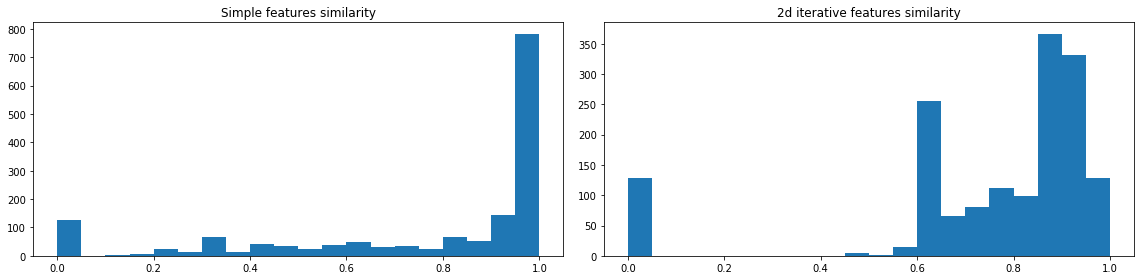

In [26]:
f, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].hist(node9similarity.values(), bins=20)
ax[0].set_title("Simple features similarity")
ax[1].hist(node9similarityK2.values(), bins=20)
ax[1].set_title("2d iterative features similarity")
f.tight_layout()
f.show()

# 2 Community detection using the Louvain algorithm

**Louvain from scratch**  
Louvain communities detection from scratch in graph tool.
Using graph_tool.inference.modularity() for calculate the modularity.

In [27]:
class LouvainPh1(object):
    def __init__(self, G):
        self.G = G
        self.communities = G.new_vertex_property("short")
        for i in G.get_vertices():
            self.communities[i] = i
        self.Modularity = inference.modularity(self.G, self.communities)
        
    def __stepForSingleVertex(self, v):
        for j in np.r_[self.G.get_in_neighbors(v), self.G.get_out_neighbors(v)]:
            newCommunities = self.communities.copy()
            newCommunities[int(v)] = newCommunities[j]
            newModularity = inference.modularity(self.G, newCommunities)
            if (newModularity > self.Modularity):
                self.Modularity = newModularity
                self.communities = newCommunities
                
    def __optimizationStep(self):
        oldModularity = copy(self.Modularity)
        for v in self.G.vertices():
            self.__stepForSingleVertex(v)
            
        if (oldModularity != self.Modularity):
            return 1
        else:
            return 0
        
    def fit(self, maxIter = 100):
        reachMaxIt = True
        for i in range(maxIter):
            res = self.__optimizationStep()
            if (res == 0):
                print("Stop at iteration %d" % (i+1))
                reachMaxIt = False
                break
                
        if (reachMaxIt):
            print("Max iteration reached.")
        
    def getCommunitiesTable(self):
        return Counter(self.communities.get_array()).most_common()

In [28]:
class Louvain(object):
    def __init__(self, G, weighted=True, firstPhaseMaxIter=100):
        self.G = G.copy()
        self.weighted = weighted
        self.__louvainPh1 = LouvainPh1(G)
        self.firstPhaseMaxIter = firstPhaseMaxIter
        
    def __getCommunityCommunityEdges(self, comm1, comm2):
        verticesC1 = np.where(self.__louvainPh1.communities.get_array() == comm1)[0]
        verticesC2 = np.where(self.__louvainPh1.communities.get_array() == comm2)[0]
        
        comm_comm_Edges = []
        
        for v in verticesC1:
            for inE in self.G.vertex(v).in_edges():
                if (int(inE.source()) in verticesC2):
                    comm_comm_Edges.append(inE)
                    
            for outE in self.G.vertex(v).out_edges():
                if (int(outE.target()) in verticesC2):
                    comm_comm_Edges.append(outE)
                    
        return comm_comm_Edges
    
    def __fitIteration(self):        
        print("Modularity on Phase-1 is %.4f" % self.__louvainPh1.Modularity)
        print("Finish Phase-1 process... Create the new Graph")
        newG = Graph(directed=True)
        
        self.__commArray = np.unique(self.__louvainPh1.communities.get_array())
        newVertices = {comm: vertID for (vertID, comm) in enumerate(self.__commArray)}
        newG.add_vertex(len(self.__commArray))
        print("Create the Graph with %d-vetices" % newG.num_vertices())
        
        print("Add edges and calculate weights...")
        newWeights = {}
        oldWeights = self.G.properties[("e", "weights")]
        
        for (s, t) in [(i, j) for i in self.__commArray for j in self.__commArray]:
            nE = 0
            w = 0
            for eInner in self.__getCommunityCommunityEdges(s, t):
                w += oldWeights[eInner]
                nE += 1
            
            if (nE > 0):
                e = newG.add_edge(newVertices[s], newVertices[t])
                newWeights[e] = w / 2*nE
        
        print("Added %d edeges" % newG.num_edges())
        
        weights = newG.new_edge_property("double")
        print("Start weight updating...")
        for e in newWeights.keys():
            weights[e] = newWeights[e]
        
        newG.edge_properties["weights"] = weights
        print("Finish the weights updating process!")
        
        oldMod = copy(self.Modularity)
        print("The new Graph have %d vertices and %d edges." % (newG.num_vertices(), newG.num_edges()))
        self.G = newG.copy()
        self.__louvainPh1 = LouvainPh1(self.G)
        self.__louvainPh1.fit(self.firstPhaseMaxIter)
        
        print("The new Modularity is %.4f" % self.__louvainPh1.Modularity)
        self.Modularity = self.__louvainPh1.Modularity
        
        if (oldMod < self.Modularity):
            return 1
        else:
            return 0
        
    def fit(self, maxIter=10):
        if not self.weighted:
            weights = self.G.new_edge_property("double")
            for e in self.G.edges():
                weights[e] = 1
            self.G.edge_properties["weights"] = weights
        
        reachMaxIt = True
        for i in range(maxIter):
            print("Start %d-GlobalIteration..." % (i+1))
            self.__louvainPh1.fit(self.firstPhaseMaxIter)
            self.Modularity = self.__louvainPh1.Modularity
            res = self.__fitIteration()
            if (res == 0):
                print("Stop at GloabalIteration %d" % (i+1))
                reachMaxIt = False
                break
                
        if (reachMaxIt):
            print("Max GloabalIteration reached.")
    
    def getCommunities(self):
        return self.__louvainPh1.communities

**Applying Louvain to Science Network**

In [29]:
louvain = Louvain(netScience, weighted=False)

In [30]:
louvain.fit()

Start 1-GlobalIteration...
Stop at iteration 7
Modularity on Phase-1 is 0.8749
Finish Phase-1 process... Create the new Graph
Create the Graph with 501-vetices
Add edges and calculate weights...
Added 619 edeges
Start weight updating...
Finish the weights updating process!
The new Graph have 501 vertices and 619 edges.
Stop at iteration 3
The new Modularity is 0.8508
Stop at GloabalIteration 1


In [31]:
pos_ = draw.sfdp_layout(louvain.G)

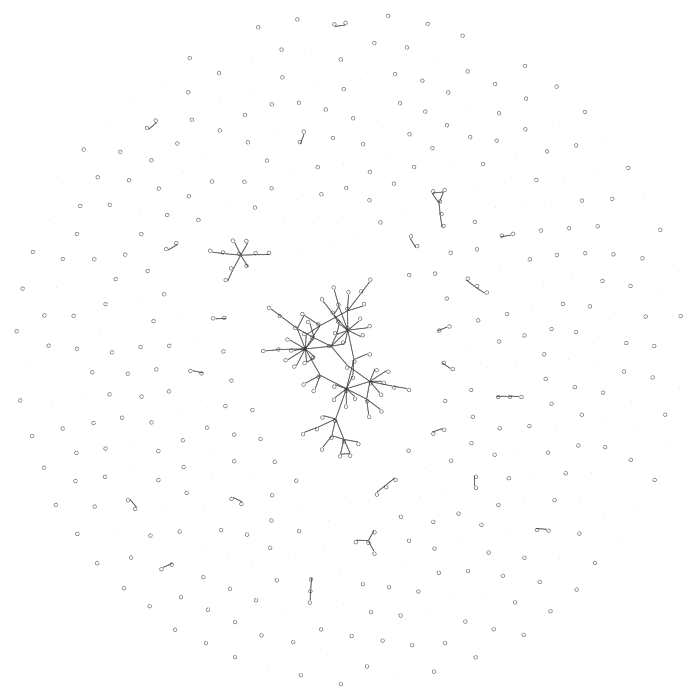

In [32]:
draw.graph_draw(louvain.G, pos_, output_size=(700, 700),
                vertex_size=0.5, edge_pen_width=0.6, output="plots/netScienceAfterLouvain.png")
plt.show()

# 3. The Configuration Model and Motif Detection

**3.1 The Configuration Model**  
Implement “edge rewiring” for the US power grid graph. To do this, load the USpowergrid n4941.txt dataset as a PNGraph and iteratively repeat the following process:

1. Randomly select two distinct edges $e_1 = (a, b)$ and $e_2 = (c, d)$ from the graph. Now, try to re-wire these edges.
2. Randomly select one of endpoint of edge $e_1$ and call it $u$. Let $v$ be the other endpoint in $e_1$. At this point, either $u = a$, $v = b$ or $u = b$, $v = a$. Do the same for edge $e_2$. Call the randomly selected endpoint $w$ and the other endpoint $x$.
3. Perform the rewiring. In the graph, replace the directed edges $e_1 = (a, b)$ and $e_2 = (c, d)$ with the directed edges $(u,w)$ and $(v, x)$ as long as this results in a simple network (no self-loops or multi-edges). If the result is not a simple network, reject this rewiring and return to step 1; otherwise, keep the newly swapped edges and return to step 1.

In [33]:
usPowerGrid = load_graph_from_csv("data/USPowerGrid/USpowerGrid.mtx",
                                  csv_options={"delimiter": " "}, directed=True)

In [34]:
usPowerGrid

<Graph object, directed, with 4943 vertices and 6596 edges at 0x7fb0dc767da0>

In [35]:
posUsPower = draw.sfdp_layout(usPowerGrid)

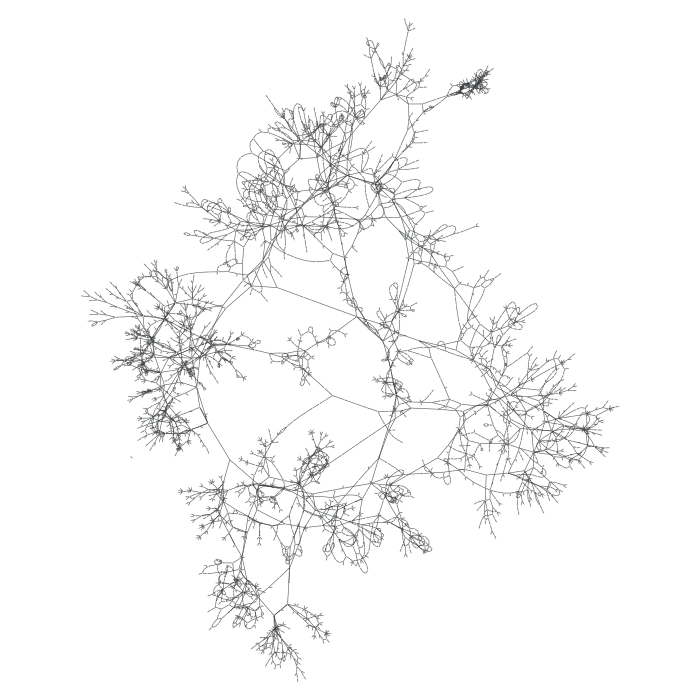

In [36]:
draw.graph_draw(usPowerGrid, posUsPower, output_size=(700, 700),
                vertex_size=0.5, edge_pen_width=0.6, output="plots/USPoerGridNet.png")
plt.show()

In [37]:
class RandomRewiring(object):
    def __init__(self, G):
        self.G = G.copy()
        self.permutationHistory = []
        
    def rewire(self, nIter=100, verbose=500):
        for i in range(nIter):
            globalCC = clustering.global_clustering(self.G)
            self.permutationHistory.append(globalCC)
            if (i % verbose == 0):
                print("The AvgCC at stage %d is %.5fe-3+-%.5fe-3" % (i, globalCC[0]*1e3, globalCC[1]*1e3))
            e1, e2 = self.getRandomEdges()
            
            if (np.random.rand() >= 0.5):
                u = e1[0]
                v = e1[1]
            else:
                u = e1[1]
                v = e1[0]
                
            if (np.random.rand() >= 0.5):
                w = e2[0]
                x = e2[1]
            else:
                w = e2[1]
                x = e2[0]
                
            if (not self.G.edge(u, w) is None):
                if (u != w):
                    self.G.add_edge(u, w)
                    self.G.remove_edge(self.G.edge(e1[0], e1[1]))
            
            if (not self.G.edge(v, x) is None):
                if (v != x):
                    self.G.add_edge(v, x)
                    self.G.remove_edge(self.G.edge(e2[0], e2[1]))
    
    def getRandomEdges(self):
        e1 = self.G.get_edges()[np.random.randint(self.G.num_edges())]
        e2 = self.G.get_edges()[np.random.randint(self.G.num_edges())]
        while (e1[2] == e2[2]):
            e2 = self.G.get_edges()[np.random.randint(self.G.num_edges())]
        
        return (e1, e2)
    
    def plotHistory(self):
        if (len(self.permutationHistory) == 0):
            print("No history!")
            return None
        
        x = np.arange(len(self.permutationHistory))
        y = [i[0] for i in self.permutationHistory]
        yerr = [i[1] for i in self.permutationHistory]
        
        f = plt.figure(figsize=(12, 4))
        ax = plt.subplot()
        ax.errorbar(x, y, yerr=yerr, fmt='.', elinewidth=0.01)
        ax.set_xlabel("Number of rewiring")
        ax.set_ylabel("Avg clustering coefficient")
        
        return f

In [38]:
randomPermuter = RandomRewiring(usPowerGrid)

In [39]:
randomPermuter.rewire(nIter=15000, verbose=1000)

The AvgCC at stage 0 is 103.11510e-3+-4.10344e-3
The AvgCC at stage 1000 is 103.13523e-3+-4.10396e-3
The AvgCC at stage 2000 is 102.64534e-3+-4.09336e-3
The AvgCC at stage 3000 is 102.64534e-3+-4.09336e-3
The AvgCC at stage 4000 is 102.64534e-3+-4.09336e-3
The AvgCC at stage 5000 is 102.55056e-3+-4.08875e-3
The AvgCC at stage 6000 is 102.55056e-3+-4.08875e-3
The AvgCC at stage 7000 is 102.55056e-3+-4.08875e-3
The AvgCC at stage 8000 is 102.55056e-3+-4.08875e-3
The AvgCC at stage 9000 is 102.55056e-3+-4.08875e-3
The AvgCC at stage 10000 is 102.37592e-3+-4.08071e-3
The AvgCC at stage 11000 is 102.37592e-3+-4.08071e-3
The AvgCC at stage 12000 is 102.94971e-3+-4.14227e-3
The AvgCC at stage 13000 is 102.66420e-3+-4.12082e-3
The AvgCC at stage 14000 is 102.66420e-3+-4.12082e-3


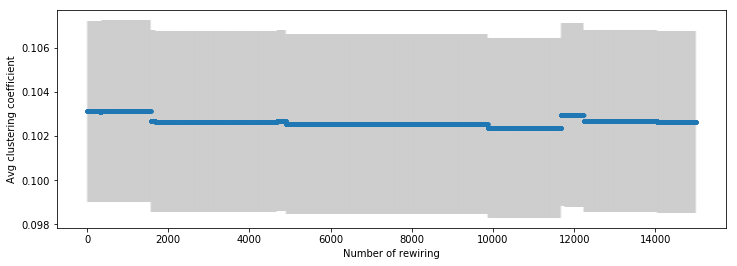

In [40]:
randomPermuter.plotHistory()
plt.show()

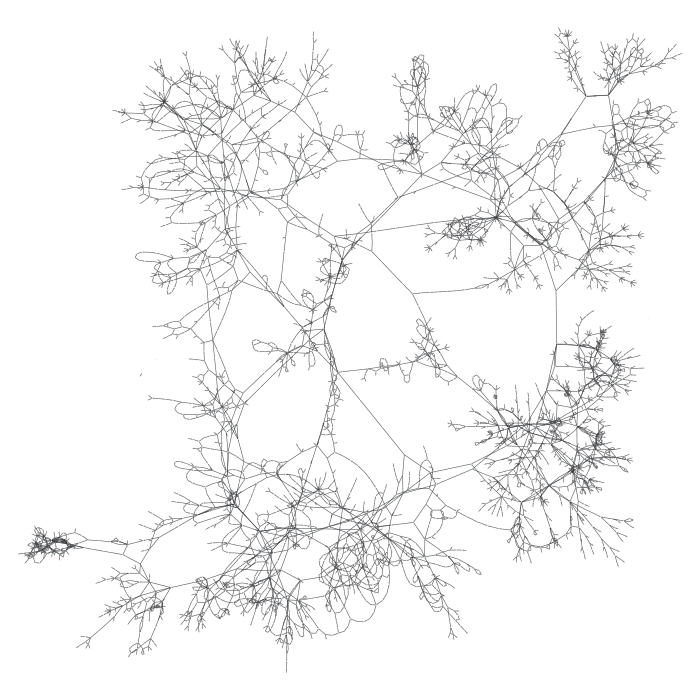

In [41]:
posUsPowerPermuted = draw.sfdp_layout(randomPermuter.G)
draw.graph_draw(randomPermuter.G, posUsPowerPermuted, output_size=(700, 700),
                vertex_size=0.5, edge_pen_width=0.6, output="plots/USPowerGridNetPermuted.png")
plt.show()

**3.2 Exact Subgraph Enumeration**  

ESU from scratch in graph tool.

In [213]:
class ExactSubgraphEnumeration(object):
    def __init__(self, G, k):
        self.G = G.copy()
        self.K = k
        
    def ExtendSubgraph(self, VSubgraph, VExtention, v):
        if (len(VExtention) > 0):
            w = VExtention.pop(np.random.randint(len(VExtention)) - 1)
            newVExtention = copy(VExtention)\
                + [u for u in self.exclusiveNeighborhood(VExtention, w) if int(u) > int(v)]
            newVSubgraph = VSubgraph.copy()
            newVSubgraph[int(w)] = 1
            if (sum(newVSubgraph) == self.K):
                #print(sum(newVSubgraph))
                #print("Found the subgraph!")
                return Graph(GraphView(self.G, newVSubgraph), prune=True)
            res = self.ExtendSubgraph(newVSubgraph, newVExtention, v)            
        else:
            #print("No result for given vertex. Go next.")
            res = None
        
        return res
            
    def openNeighborHood(self, V):
        allVNeighborHood = []
        for v in V:
            for u in v.all_neighbors():
                if (u not in allVNeighborHood):
                    allVNeighborHood.append(u)
        
        return allVNeighborHood
    
    def exclusiveNeighborhood(self, V, w):
        NV = self.openNeighborHood(V)
        NV_V = NV + V
        result = [u for u in w.all_neighbors() if u not in NV_V]
        
        return result
    
    def enumerateSubgraph(self):
        listOfSubgraphs = []
        for (i, v) in enumerate(self.G.vertices()):
            VExtention = [u for u in self.openNeighborHood([v]) if int(u) > int(v)]
            if (len(VExtention) == 0):
                next
            VSubgraph = self.G.new_vertex_property("bool")
            VSubgraph[int(v)] = 1
            res = self.ExtendSubgraph(VSubgraph.copy(), copy(VExtention), v)
            if (not res is None):
                listOfSubgraphs.append(res)
            if ((i % 100) == 0):
                print("Iteration number {} Processed {:.2f}% of vertices".format(i, 100.0*i/self.G.num_vertices()))
        
        return listOfSubgraphs

In [214]:
esu = ExactSubgraphEnumeration(usPowerGrid, 3)

In [216]:
listOfGraphlets = esu.enumerateSubgraph()

Iteration number 0 Processed 0.00% of vertices
Iteration number 100 Processed 2.02% of vertices
Iteration number 200 Processed 4.05% of vertices
Iteration number 300 Processed 6.07% of vertices
Iteration number 400 Processed 8.09% of vertices
Iteration number 500 Processed 10.12% of vertices
Iteration number 600 Processed 12.14% of vertices
Iteration number 700 Processed 14.16% of vertices
Iteration number 800 Processed 16.18% of vertices
Iteration number 900 Processed 18.21% of vertices
Iteration number 1000 Processed 20.23% of vertices
Iteration number 1100 Processed 22.25% of vertices
Iteration number 1200 Processed 24.28% of vertices
Iteration number 1300 Processed 26.30% of vertices
Iteration number 1400 Processed 28.32% of vertices
Iteration number 1500 Processed 30.35% of vertices
Iteration number 1600 Processed 32.37% of vertices
Iteration number 1700 Processed 34.39% of vertices
Iteration number 1800 Processed 36.42% of vertices
Iteration number 1900 Processed 38.44% of vertic

In [221]:
def getIsoGraphs(listOfSubgraphs):
    graphs = copy(listOfSubgraphs)
    result = {}
    while (len(graphs) > 0):
        currentG = graphs[0]
        tmpResults = []
        
        for g in graphs:
            tmpResults.append(topology.isomorphism(currentG, g))
            
        result[currentG] = sum(tmpResults)
        graphs = [g for (i, g) in enumerate(graphs) if not tmpResults[i]]
        
    return result

In [222]:
res = getIsoGraphs(listOfGraphlets)

In [233]:
res

{<Graph object, directed, with 3 vertices and 3 edges at 0x7fb0cf095f98>: 1,
 <Graph object, directed, with 3 vertices and 2 edges at 0x7fb0cf0950b8>: 638,
 <Graph object, directed, with 3 vertices and 2 edges at 0x7fb0cf0956d8>: 850,
 <Graph object, directed, with 3 vertices and 2 edges at 0x7fb0cf09a320>: 922,
 <Graph object, directed, with 3 vertices and 3 edges at 0x7fb0cf071be0>: 98}

In [235]:
def plotG(G):
    pos = draw.random_layout(G)
    draw.graph_draw(G, pos, output_size=(100, 100))

**Results:**

1 graphlet of type 1:

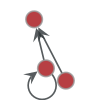

In [236]:
plotG(list(res.keys())[0])

638 graphlets if type 2:

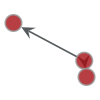

In [237]:
plotG(list(res.keys())[1])

850 graphlets of type 3:

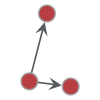

In [238]:
plotG(list(res.keys())[1])

922 graplets of type 4:

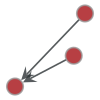

In [239]:
plotG(list(res.keys())[2])

98 graphlets of type 5:

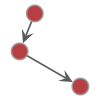

In [240]:
plotG(list(res.keys())[3])

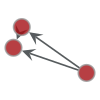

In [241]:
plotG(list(res.keys())[4])